In [1]:
from cheetah import Segment, ParticleBeam
import torch
import torch.nn as nn
import torch.nn.functional as F
import epics
import os
import numpy as np
import pprint
import h5py
from typing import List, Dict, Any, Callable
import yaml
import matplotlib.pyplot as plt

In [2]:
def extract_group_contents(group, exclude_keys=None):
    """Safely extract datasets from a group, handling scalars and nested groups."""
    if exclude_keys is None:
        exclude_keys = set()
    data = {}
    for key in group:
        if key in exclude_keys:
            continue
        item = group[key]
        if isinstance(item, h5py.Dataset):
            data[key] = item[()] if item.shape == () else item[:]
        elif isinstance(item, h5py.Group):
            data[key] = extract_group_contents(item, exclude_keys)
    return data


images = {}
with h5py.File('../h5/tcav_calibration.h5', 'r') as f:
    image_root = f['images']
    exclude_keys = {'raw_images','processed_images','total_intensities', 'signal_to_noise_ratios'}

    for image_key in image_root:
        image_group = image_root[image_key]
        image_data = extract_group_contents(image_group, exclude_keys=exclude_keys)
        images[image_key] = image_data



In [3]:
# Since all the quad settings are matched in the simulated server and calibration file the only PVs we care about is tcav AREQ, PREQ
# Can extract these values from the group contents pretty easily
# We will also plot the average beam size x measurement versus phase

keys = [key for key in images.keys()]
centroid_stack = np.stack([
    np.nanmean(images[key]['centroids'],axis=0) for key in keys])
phase_stack = np.stack([
    images[key]['TCAV:DIAG0:11:PREQ'] for key in images])



In [4]:
from scipy.optimize import curve_fit
X= phase_stack
Y= centroid_stack
# 1. Linear fit for centroid X
def linear(x, m, b):
    return m * x + b

params_x, _ = curve_fit(linear, X, Y[:, 0])
fit_x = linear(X, *params_x)

# 2. Sine fit for centroid Y (still using degrees)
def sine_deg(x_deg, amplitude, phase_shift, frequency, offset):
    x_rad = np.radians(x_deg)
    return amplitude * np.sin(frequency * x_rad + phase_shift) + offset

p0_y = [np.ptp(Y[:, 1]) / 2, 0.0, 1.0, np.mean(Y[:, 1])]
params_y, _ = curve_fit(sine_deg, X, Y[:, 1], p0=p0_y)
fit_y = sine_deg(X, *params_y)

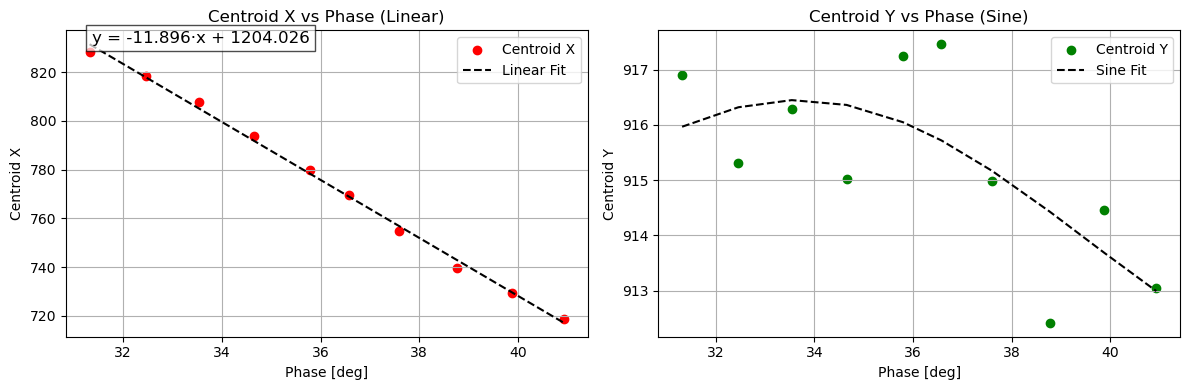

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Centroid X (Linear)
axes[0].scatter(X, Y[:, 0], color='red', label='Centroid X')
axes[0].plot(X, fit_x, color='black', linestyle='--', label='Linear Fit')
axes[0].set_title('Centroid X vs Phase (Linear)')
axes[0].set_xlabel('Phase [deg]')
axes[0].set_ylabel('Centroid X')
axes[0].legend()
axes[0].grid(True)
# Suppose params_x = [m, b]
eqn_x = f"y = {params_x[0]:.3f}·x + {params_x[1]:.3f}"
axes[0].text(0.05, 0.95, eqn_x, transform=axes[0].transAxes,
             fontsize=12, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.7))

# Centroid Y (Sine)
axes[1].scatter(X, Y[:, 1], color='green', label='Centroid Y')
axes[1].plot(X, fit_y, color='black', linestyle='--', label='Sine Fit')
axes[1].set_title('Centroid Y vs Phase (Sine)')
axes[1].set_xlabel('Phase [deg]')
axes[1].set_ylabel('Centroid Y')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [6]:
from lcls_tools.common.devices.reader import create_screen, create_tcav, create_magnet
from ml_tto.automatic_emittance.screen_profile import ScreenBeamProfileMeasurement
from ml_tto.automatic_emittance.image_projection_fit import RecursiveImageProjectionFit
from ml_tto.automatic_emittance.plotting import plot_image_projection_fit

In [7]:
def show_side_by_side(img1: np.ndarray, img2: np.ndarray, titles=('Original', 'Noisy'), cmap='hot'):
    """
    Plot two 2D images side-by-side as heat maps.

    Parameters:
        img1, img2 (np.ndarray): 2D arrays to plot.
        titles (tuple): Titles for the subplots.
        cmap (str): Colormap to use.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, img, title in zip(axes, [img1, img2], titles):
        im = ax.imshow(img, cmap=cmap, origin='lower', aspect='auto')
        ax.set_title(title)
        ax.set_xlabel('X pixels')
        ax.set_ylabel('Y pixels')
        fig.colorbar(im, ax=ax, shrink=0.75, label='Intensity')
    plt.tight_layout()
    plt.show()

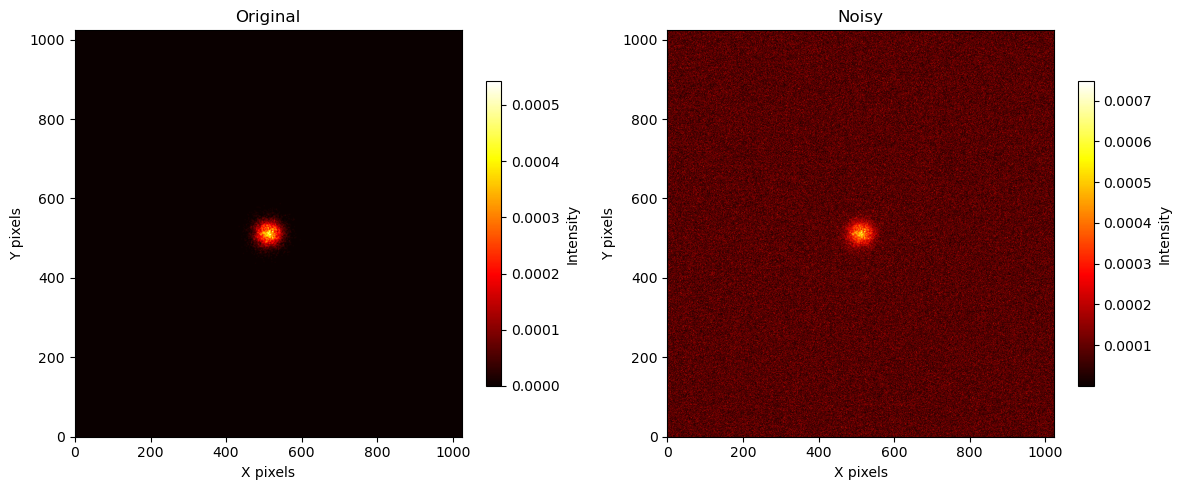

In [ ]:
#Start server, track screen, fit beam get result, vary phase repeat for each phase in phase_stack, use lcls_tools library to control
# the screen, tcav, and magnets if needed

screen = create_screen('DIAG0', 'OTRDG02')
#tcav = create_tcav('DIAG0', 'TCXDG0')

images = []
image =  screen.image 
noise_std = 0.2 * np.max(image)
image_noisey = image + np.abs(np.random.normal(loc=0, scale=noise_std, size=image.shape))
show_side_by_side(image,image_noisey)
for phase in phase_stack:
    epics.caput('TCAV:DIAG0:11:PREQ', phase)
    image =  screen.image
    noise_std = 0.2 * (np.max(image) + .0001)
    image += np.abs(np.random.normal(loc=0, scale= noise_std , size=image.shape))
    images.append(image)

#TODO: fix tcav.phase_set not fucking working

In [ ]:
#Fit images get centroids

#recImg = RecursiveImageProjectionFit(visualize=True)
#recImg._fit_image(image=images[0])



ValidationError: 1 validation error for ImageProjectionFitResult
total_intensity
  Input should be greater than 0 [type=greater_than, input_value=np.float64(0.0), input_type=float64]
    For further information visit https://errors.pydantic.dev/2.10/v/greater_than

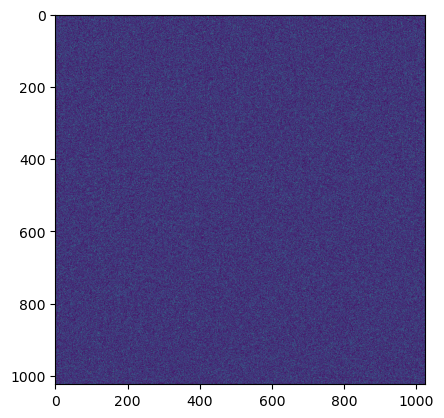

In [ ]:
plt.imshow(images[9])